In [1]:
# import Oracle_Assignment_2 as oa
# import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# oa.q2_get_mnist_jpg_subset(23634)


In [2]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset



In [3]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert to tensor
])


In [4]:



dataset = datasets.ImageFolder(root="q2_data", transform=transform)

# Split dataset into training and test sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:


def evaluate(model, train_loader, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    correct, total = 0, 0
    with torch.no_grad() :
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Train Accuracy: {100 * correct / total:.2f}%")


def train(model, train_loader, criterion, optimizer, device, epochs, test_loader):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update weights using SGD with momentum

            total_loss += loss.item()

        # evaluate(model, train_loader, test_loader, device)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


def metricslearn(model, train_loader, test_loader, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


def dataloader_to_numpy(dataloader):
    data_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.numpy().reshape(images.shape[0], -1)
        data_list.append(images)
        labels_list.append(labels.numpy())

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)
    return data_array, labels_array

train_data, train_labels = dataloader_to_numpy(train_loader)
test_data, test_labels = dataloader_to_numpy(test_loader)


def pca(data, k) :
    cov_matrix = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]


    eigenvectors = eigenvectors[:, idx]
    eigenvalues = eigenvalues[idx]
    eigenvecks = eigenvectors[:, :k]
    new_data = np.dot(data, eigenvecks)
    return new_data, eigenvecks




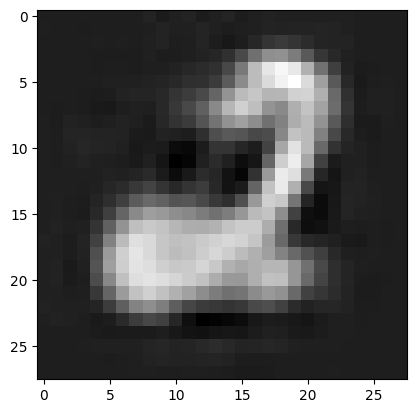

In [6]:


mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
k = 100
train_data_pca, eigenvecks = pca(train_data, k)
test_data_pca = np.dot(test_data, eigenvecks)



# Convert PCA-transformed data to tensors
train_data_pca_tensor = torch.tensor(train_data_pca, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_pca_tensor = torch.tensor(test_data_pca, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader
train_pca_dataset = TensorDataset(train_data_pca_tensor, train_labels_tensor)
test_pca_dataset = TensorDataset(test_data_pca_tensor, test_labels_tensor)

train_pca_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True)
test_pca_loader = DataLoader(test_pca_dataset, batch_size=32, shuffle=False)

# Reconstruct a sample image
sample = train_data_pca[10]
reconstructed = np.dot(sample, eigenvecks.T)
reconstructed = (reconstructed * std) + mean
reconstructed = reconstructed.reshape(28, 28)
plt.imshow(reconstructed, cmap="gray")

 


In [9]:
from kan import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = KAN(width=[100,10,20,10],grid =5 ,k=3,seed=42,device=device).to(device)



checkpoint directory created: ./model
saving model version 0.0


In [10]:

len(train_pca_dataset)
for i in train_pca_dataset:
    print (i)
    break


# train(model,train_data_pca)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(model, train_pca_loader, criterion, optimizer, device, epochs=17, test_loader = test_pca_loader)



model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")




(tensor([-0.8410, -3.5703, -4.1523, -9.2323,  3.2586,  3.2736, -0.4720,  1.7042,
        -5.1720, -6.2205, -5.2815, -0.6185,  0.1433, -1.6192, -2.3616, -0.0113,
        -0.1836, -0.1510, -0.8277,  2.0887,  0.6677,  0.7742,  1.7195,  1.8318,
        -0.7935, -0.6966,  2.6199,  3.5512,  1.0218,  2.7797,  1.0196, -1.7061,
        -3.8021,  1.2898,  2.6860, -1.1304,  0.9435,  0.5946,  1.2168, -0.4166,
         1.7943,  0.1758,  1.4968, -2.2573, -1.3422, -0.5738, -2.0050,  0.7454,
        -1.3775, -1.1532, -2.3072,  1.7029, -1.8015, -3.2567, -0.4191,  1.2417,
        -0.2546,  0.4208,  1.0112,  0.2721, -0.3679,  2.1983,  0.3614, -1.7663,
        -0.9487, -1.9230, -0.6400, -1.1878,  1.4066,  0.3213, -0.4821,  0.3734,
        -0.0194,  0.0687,  0.5277,  0.4679, -1.6277, -0.7312, -0.0867,  0.6921,
        -1.9358, -0.0751, -1.3049, -1.0311,  0.2768,  1.3655, -0.3048,  2.4794,
        -0.8698,  1.3364, -0.2179, -1.1997,  0.8484, -0.6041,  1.1325, -0.1296,
         0.1251,  1.7323, -0.4565, -0.0

In [12]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.15%
Train Accuracy: 88.34%


In [11]:



class MLPPCA(nn.Module):
    def __init__(self):
        super(MLPPCA, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(117, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA = MLPPCA()


modelMLPPCA = MLPPCA().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA.parameters(), lr=0.01, momentum=0.9)
train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
 

TypeError: LBFGS.__init__() got an unexpected keyword argument 'momentum'